In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
sns.set() # устанавливаем seaborn как по-умолчанию для отрисовки графиков

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
X = pd.read_csv('../Data/new_date_riverV1.csv',parse_dates=["date"])
X = X.drop(['Unnamed: 0'],axis=1)

In [3]:
X = X.drop(['w_forecast_d2','w_forecast_d3','w_forecast_d4','w_forecast_d5',
           'w_forecast_d6','w_forecast_d7','w_forecast_d8','w_forecast_d9',
            'w_forecast_d10','w_forecast_d11','w_forecast_d12','w_forecast_d13','w_forecast_d14', 
            'pasday1',
           ], axis=1)


In [4]:
test_general = X[(X['date']>= '2018-01-01') & (X['date']<= '2021-12-31')] #выборка для ручного теста
X = X.drop(X[(X['date']>= '2018-01-01') & (X['date']<= '2021-12-31')].index) #убираем выборку из обучающего сета

In [5]:
#размножаем признаки post_9487 которых больше 200
v =  X.loc[X[X['post_9387']>=200].index.repeat(1)].reset_index(drop=True)
X = pd.concat([X,v], ignore_index=True)
#размножаем признаки post_9487 которых больше 70 но меньше 200
v = X.loc[X[(X['post_9387']>=70) & (X['post_9387']<200)].index.repeat(1)].reset_index(drop=True)
X = pd.concat([X,v], ignore_index=True)
#размножаем признаки post_9487 которых с 100 дня до 125
v = X.loc[X[(X['day_of_year']>=100) & (X['day_of_year']<150)].index.repeat(1)].reset_index(drop=True)
X = pd.concat([X,v], ignore_index=True)

# #размножаем признаки post_9487 которых с 120 дня до 130
# v = X.loc[X[(X['day_of_year']>=120) & (X['day_of_year']<130)].index.repeat(2)].reset_index(drop=True)
# X = pd.concat([X,v], ignore_index=True)


print(len(X[X['post_9387']>=200]))
print(len(X[X['post_9387']<200]))

1084
3998


In [6]:
#метод для тестирование предсказаний
#start_date - начало даты предсказания уровня воды
def tester(start_date):     
    
    #Конвертируем дату(строки) в дату (datetime64)  
    date_start = pd.to_datetime(start_date, format="%Y-%m-%d") #начало 
    date_end = date_start + datetime.timedelta(days=13)     # пребовляем 2 недели 13
    plot_start = pd.to_datetime(datetime.date(date_start.year, 1, 1)) #Начало года (для графика)    
    

    #Данные для графика
    #global test_general
    #данные для графика
    X_plot = test_general[(test_general['date']>= plot_start) & (test_general['date']<= date_start)]


    temp = test_general[(test_general['date']>= date_start) & (test_general['date']<= date_end)]
    Check_level = temp['post_9387'] # для проврки уровня реки (в автомате)

    Check_snow_height = np.array(temp['snow_height']) # данные предсказания о снежном покрове (в автомат)
    Check_degree_coverage = np.array(temp['degree_coverage']) # данные предсказанного снежного покртия (в автомат)

    #подготовка данных для теста автомата
    #test_general.set_index('date', inplace = True)
    #test_general = test_general.drop('day_of_year', axis=1)

    #arr = test_general[ date_start : date_start ]   
    forecast_weather = np.array(temp['w_forecast_d1'])
    
    print(temp)
    #отбираем температуру за прошлые дни (одной строкой так как она вся повторяется и в принцепе вся информация в одной записи на 2 недели назад есть)
    pasday = np.array(temp[['pasday2','pasday3','pasday4','pasday5','pasday6','pasday7',
                               'pasday8','pasday9','pasday10','pasday11','pasday12','pasday13','pasday14',
                           ]].values[0])
    #Уровень воды за прошлые дни
    pas_level = np.array(temp[['pas_level1','pas_level2','pas_level3','pas_level4','pas_level5','pas_level6','pas_level7']].values[0])
    #температуру одбираем только одну (так как нам какбуд-то не известна точная температура на 2 недели вперед )
    tmean = temp.tmean.values[0]
    
   
    future = {'Check_level':Check_level,
            'Check_snow_height': Check_snow_height,
            'Check_degree_coverage': Check_degree_coverage,
            'forecast_weather': forecast_weather,
            'pasday': pasday,
            'pas_level': pas_level,
            'tmean': tmean,
            'date_start': date_start,
            'X_plot': X_plot
           }
    

    #Возвращаем все в словаре
    return  future


In [7]:
# выделяем target из dataset
y = X.pop('post_9387')

In [8]:

X_train, X_test, Y_train, Y_test = train_test_split(X,y, train_size=0.7 , random_state=11)
X_train_date = X_train.pop('date')
X_test_date = X_test.pop('date')


# Нормализация
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[ 40.   10.  -25.2 -32.9 -22.8 -22.8 -41.2 -42.5 -37.8 -32.7 -14.1  -4.3
  -12.5  -6.4  -9.9 -21.5 105.  106.  106.  106.  106.  106.  107.  344.
  -39.9]]

Normalized: [[ 0.92  1.01 -1.38 -1.83 -1.23 -1.23 -2.31 -2.4  -2.12 -1.81 -0.69 -0.1
  -0.58 -0.22 -0.43 -1.12 -0.2  -0.19 -0.18 -0.17 -0.17 -0.16 -0.15  1.86
  -2.25]]


In [9]:
from scipy.stats import randint
from sklearn.metrics import mean_squared_error,explained_variance_score, mean_absolute_error,mean_absolute_percentage_error


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(90,input_dim=26, activation='relu',bias_initializer='glorot_normal', kernel_initializer='glorot_normal'),
      layers.Dense(80,input_dim=26, activation='relu',bias_initializer='glorot_normal', kernel_initializer='glorot_normal'),     
      layers.Dense(1,activation='linear',bias_initializer='glorot_normal', kernel_initializer='glorot_normal')
  ])

  model.compile(loss='mean_absolute_error',
                #optimizer=tf.keras.optimizers.Adam(0.001))
                optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True))
  return model

In [11]:
model = build_and_compile_model(normalizer)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 25)               51        
 n)                                                              
                                                                 
 dense (Dense)               (None, 90)                2340      
                                                                 
 dense_1 (Dense)             (None, 80)                7280      
                                                                 
 dense_2 (Dense)             (None, 1)                 81        
                                                                 
Total params: 9,752
Trainable params: 9,701
Non-trainable params: 51
_________________________________________________________________


In [17]:
# %%time
# history = model.fit(
#     X_train,
#     Y_train,
#     validation_split=0.2,    
#     verbose=0, epochs=700)


#save model
#model.save('../models/tf_dens3-80-90-1')
#load model
model = keras.models.load_model('../models/tf_dens3-80-90-1')
model.evaluate(X_train, Y_train)

112/112 [==============================] - 0s 2ms/step - loss: 4.6273


In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Ошибка обучения')
  plt.plot(history.history['val_loss'], label='Ошибка валидации')
  plt.ylim([0, 50])
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка прогноза по [post_9387]')
  plt.legend()
  plt.grid(True)

In [19]:
plot_loss(history)

AttributeError: 'float' object has no attribute 'history'

In [ ]:
test_predictions = model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(X_test['day_of_year'], Y_test)
plt.xlabel('Истинные значения [пост 9387]')
plt.ylabel('Предсказанные значения [пост 9387]')
lims = [0, 750]
plt.ylim(0,700)
plt.xlim(0,400)
_ = plt.scatter(X_test['day_of_year'], test_predictions,color='red',alpha=0.2)



In [16]:
error = test_predictions - Y_test
plt.hist(error, bins=25)
plt.xlabel('Ошибка прогноза [пост 9387]')
_ = plt.ylabel('Количество ошибок')

NameError: name 'test_predictions' is not defined

In [20]:
def predict(data):
    
    
    data = pd.DataFrame(data = data, columns = data.columns)   
    
    prdict = model.predict(data)
    
    return  prdict

In [21]:
   
print("The absolute mean error :",mean_absolute_error(Y_test, test_predictions))
print("The squared mean error :",mean_squared_error(Y_test, test_predictions))
print("The squared mean error :",np.sqrt(mean_squared_error(Y_test, test_predictions)))

# The absolute mean error : 7.675656084154473
# The squared mean error : 241.59287085341356
# The squared mean error : 15.543258051432254 600 epohes

NameError: name 'test_predictions' is not defined

In [22]:
print("The Variance Score :", explained_variance_score(Y_test, test_predictions))
#The variance shows how many percent that our model can explain,so our model can explain %58 procent accurately
#The Variance Score : 0.9920466612400378

NameError: name 'test_predictions' is not defined

### LinearRegression
     MAE = 0.39877488514548237
     MAPE = 1379356700572.9495
     MSE = 2.487826409744653

### DecisionTreeRegressor
     MAE = 0.38437978560490044
     MAPE = 1379356700572.9502
     MSE = 2.4686084268438013
     
### Catboost
      MAE = 0.8153775828433826
      MAPE = 3729137297478.792
      MSE = 1.8557184138282679

In [23]:
#X_test['date'] = X_test_date
#plt.figure(figsize=(30,20))
#ax = sns.lineplot(x = X_test['date'], y=Y_test, color='blue')
#ax = sns.lineplot(x = X_test['date'], y=predictions,color='red')
#plt.show()



In [24]:
#To Do создать окончательный автомат по предсказанию уровня реки!



def level_forecast(date,tmean, pas_level1, pasday, w_forecast, forecast_degree_coverage,forecast_snow_height):
    columns_name = ['snow_height','degree_coverage','tmean',
                   'pasday2','pasday3','pasday4','pasday5','pasday6','pasday7',
                    'pasday8','pasday9','pasday10','pasday11','pasday12','pasday13','pasday14',
                   'pas_level1','pas_level2','pas_level3','pas_level4','pas_level5','pas_level6','pas_level7',
                    'day_of_year','w_forecast_d1'
                    ]
    #Конвертируем дату(строки) в дату (datetime64)
    #date = datetime.datetime.strptime(date, "%Y-%m-%d").date()
    day_of_year = int(date.strftime("%j"))
    #data = np.insert(data, -1, day_of_year )  #временно закаментирую день гда в общем массиве
    
    
   # =============================1 проход =============================== 
    #global pas_level
  
    
    #разбиваем данные на группы
    snow_height = forecast_snow_height[0] #1 высота снежного покрова
    degree_coverage = forecast_degree_coverage[0] #2 покрытие  снега
    
    
    pas_level = pas_level1 #data[0,17:24]#18-24 уровень воды за прошлые 7 днй   
    w_forecast_d1 = w_forecast[0]# data[0,24] #25 прогноз погоды на 1 день
    
    #формируем массив с фичами
    future = np.array([snow_height,degree_coverage,tmean])
    future = np.append(future, pasday)
    future = np.append(future,pas_level)
    future = np.append(future, [day_of_year,w_forecast_d1])

    #переводим данные в DataFrame
    future = pd.DataFrame(data=[future], columns=columns_name)   
    
    

    #предсказание   
    predic_day = predict(future)#model.predict(future)  
    global prd
   # global day_number
    prd = []
    day_number = []
    prd = np.append(prd, predic_day)
    day_number = np.append(day_number,day_of_year)
    
       
   #========================================================================

    for i in range(13): 
        day_of_year += 1
        #разбиваем данные на группы
        snow_height = forecast_snow_height[i+1]#1 высота снежного покрова
        
        degree_coverage = forecast_degree_coverage[i+1] #2 покрытие  снега
        
        
        pasday = np.roll(pasday,1)#сдвигаем массив вперед        
        pasday[0] = tmean #заменяем первый элемент массива вчерашней темпреатурой
       
        
        tmean = w_forecast[i] # текущая ср.температура 
       
        pas_level = np.roll(pas_level,1)
       
        pas_level[0] = prd[i]
       
        
        #w_forecast_d1 = data[0,24] #25 прогноз погоды на 1 день
        w_forecast_d1 = w_forecast[i+1]

        #формируем массив с фичами
        future = np.array([snow_height,degree_coverage,tmean])
        future = np.append(future, pasday)
        future = np.append(future,pas_level)
        future = np.append(future, [day_of_year,w_forecast_d1])

        #переводим данные в DataFrame
        future = pd.DataFrame(data=[future], columns=columns_name) 
        
       
        #предсказание   
        predic_day = predict(future)#model.predict(future)
        
        prd = np.append(prd, predic_day)
        day_number = np.append(day_number,day_of_year)  
        #print(prd)
        
        #prd =  np.linspace (prd.min(), prd.max(), len(prd) )
        #print(prd)
    
    return {'predict':prd, 'day_number':day_number}

In [25]:
#метод для вывода графика с предсказанным уровнем
def ploting (data,  predict_level_day, predict_data, test_data):
    
    #predict_data = np.linspace(predict_data.min(), predict_data.max(), len(predict_data)) 
    
    sns.lineplot(data=data, x="day_of_year", y="post_9387")
    sns.lineplot(x=predict_level_day, y=predict_data,color='Red')   
    sns.lineplot(x=predict_level_day, y=test_data,color='green')
    
    plt.show()

    #MSE 
def metrics_predict(pred, test, msg=''):
    print(f"{msg} The absolute mean error :",mean_absolute_error(test, pred))
    print(f"{msg} The squared mean error :",mean_squared_error(test, pred))
    print(f"{msg} The squared mean error :",np.sqrt(mean_squared_error(test, pred)))
    

           date  snow_height  degree_coverage  tmean  post_9387  pasday2  \
3748 2020-04-05           56               10   -1.9         61      2.1   
3749 2020-04-06           54               10    1.1         62      2.5   
3750 2020-04-07           52               10    2.5         62     -1.9   
3751 2020-04-08           47               10    4.3         64      1.1   
3752 2020-04-09           42               10    4.9         66      2.5   
3753 2020-04-10           36               10    3.5         68      4.3   
3754 2020-04-11           30               10    2.8         69      4.9   
3755 2020-04-12           25               10    2.8         70      3.5   
3756 2020-04-13           23               10    2.7         71      2.8   
3757 2020-04-14           21               10    4.0         71      2.8   
3758 2020-04-15           18               10    4.4         72      2.7   
3759 2020-04-16           15               10    4.3         80      4.0   
3760 2020-04

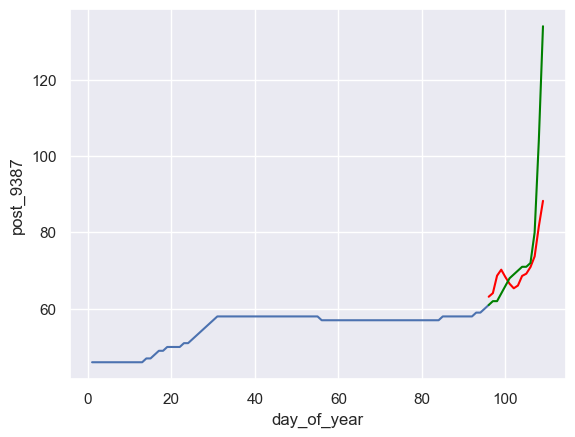

 The absolute mean error : 7.729866027832031
 The squared mean error : 198.13291228824528
 The squared mean error : 14.075969319668372
           date  snow_height  degree_coverage  tmean  post_9387  pasday2  \
3749 2020-04-06           54               10    1.1         62      2.5   
3750 2020-04-07           52               10    2.5         62     -1.9   
3751 2020-04-08           47               10    4.3         64      1.1   
3752 2020-04-09           42               10    4.9         66      2.5   
3753 2020-04-10           36               10    3.5         68      4.3   
3754 2020-04-11           30               10    2.8         69      4.9   
3755 2020-04-12           25               10    2.8         70      3.5   
3756 2020-04-13           23               10    2.7         71      2.8   
3757 2020-04-14           21               10    4.0         71      2.8   
3758 2020-04-15           18               10    4.4         72      2.7   
3759 2020-04-16           15 

In [ ]:
test1 = ['2018-04-01','2018-04-02','2018-04-03','2018-04-04','2018-04-05','2018-04-06',
              '2018-04-07','2018-04-08','2018-04-09','2018-04-10','2018-04-11','2018-04-12']

test2 = ['2020-04-05','2020-04-06',
             '2020-04-07', '2020-04-08','2020-04-09','2020-04-10', '2020-04-11','2020-04-12',
          '2020-04-13','2020-04-14', '2020-04-15','2020-04-16']

test3 = ['2020-05-05','2020-05-06',
             '2020-05-07', '2020-05-08','2020-05-09','2020-05-10', '2020-05-11','2020-05-12',
          '2020-05-13','2020-05-14', '2020-05-15','2020-05-16']

test4 = ['2018-05-05','2018-05-06',
             '2018-05-07', '2018-05-08','2018-05-09','2018-05-10', '2018-05-11','2018-05-12',
          '2018-05-13','2018-05-14', '2018-05-15','2018-05-16']

pred_arr = np.array([])
check_level_arr = np.array([])
for d in test2:
     
    data = tester(d) 
    predict_level = level_forecast(data['date_start'],data['tmean'], data['pas_level'],data['pasday'], 
                            data['forecast_weather'], data['Check_degree_coverage'], data['Check_snow_height'])
    
    ploting(data['X_plot'], predict_level['day_number'], predict_level['predict'], data['Check_level'])
    
    pred_arr =  np.append( pred_arr, predict_level['predict'])
    check_level_arr = np.append(check_level_arr, data['Check_level'])
    
    metrics_predict(predict_level['predict'], data['Check_level'])


metrics_predict( check_level_arr.flatten(), pred_arr.flatten(), 'FINAL',)

In [94]:
# FINAL The absolute mean error : 12.017057748067947
# FINAL The squared mean error : 378.9977450455011
# FINAL The squared mean error : 19.46786441922948
metrics_predict( check_level_arr.flatten(), pred_arr.flatten(), 'FINAL',)

FINAL The absolute mean error : 125.42841176759629
FINAL The squared mean error : 20419.205746723932
FINAL The squared mean error : 142.89578631549614


In [ ]:
#metrics(data['Check_level'], predict_level['predict'])